In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1 - Reading Input files into pandas dataframes:

#### 1.1 Reading Movies into a dataframe 
please note that *imdb_movies* already contains content of *imdb_keywords* and *imdb_casts*.

In [3]:
movie_df = pd.read_csv('/content/drive/MyDrive/imdb_datasets/imdb_movies.csv')
movie_df.set_index('movie_id', inplace=True)
movie_df.sample(5)

,name,org_name,date,title_year,point,point_volume,metascore,user_reviews,critic_reviews,director,writer,story_line,cast,genres,country,language,budget,world_gross,usa_gross,runtime,production_companies,dollar_budget,w_gross_money,u_gross_money,inflation_coeff,casts_id,BlogPage,CompPage,HomePage,release_month,release_day,keywords
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0124056,Picasso,Picasso,1985-01-01,1985.0,7.2,27.0,NaN,1.0,1.0,wridir_not_provided,wridir_not_provided,story_line_not_provided,"Féodor Atkine,Georges Braque,Henri Matisse,Ale...","Documentary,Biography",Canada,English,NaN,NaN,NaN,83.0,company_not_provided,NaN,NaN,NaN,2.418722,castIDs_not_provided,0,0,0,1.0,1.0,keys_not_provided
tt0009197,A Hoosier Romance,A Hoosier Romance,1918-08-18,1918.0,NaN,0.0,NaN,0.0,0.0,wridir_not_provided,"Colin Campbell,James Whitcomb Riley",Living with her cruel and greedy father on the...,"Colleen Moore,Harry McCoy,Eugenie Besserer,Bil...","Comedy,Drama",USA,English,NaN,NaN,NaN,NaN,Selig Polyscope Company,NaN,NaN,NaN,17.157812,castIDs_not_provided,0,0,0,8.0,18.0,"hoax,indiana"
tt0304887,Venido a menos,Venido a menos,1984-10-11,1984.0,5.3,22.0,NaN,0.0,0.0,wridir_not_provided,"Alejandro Azzano,Camilo Cappelletto",A man whose financial situation has deteriorat...,"Fernando Siro,Irma Córdoba,Sebastián Larreta,E...","Drama,Comedy",Argentina,Spanish,NaN,NaN,NaN,83.0,Filmstar,NaN,NaN,NaN,2.507078,castIDs_not_provided,0,0,0,10.0,11.0,keys_not_provided
tt0054873,A Fever in the Blood,A Fever in the Blood,1961-01-28,1961.0,6.4,196.0,NaN,12.0,7.0,Vincent Sherman,"Roy Huggins,Harry Kleiner","A district attorney, a US Senator, and a Super...","Efrem Zimbalist Jr.,Jack Kelly,Ray Danton,Andr...",Drama,USA,English,NaN,NaN,NaN,NaN,Warner Bros.,NaN,NaN,NaN,8.715079,castIDs_not_provided,0,0,0,1.0,28.0,"trial,murder"
tt6289390,Journey to the West 2000,Journey to the West 2000,2000-01-16,2000.0,7.5,27.0,NaN,0.0,0.0,wridir_not_provided,wridir_not_provided,"As book story, written in the 1940 the story o...","Benben Guo,Li Po Lung,Liu Xiao Ling Tong,Xu Sh...",Action,China,Chinese,NaN,NaN,NaN,NaN,Tianshan Film Studio,NaN,NaN,NaN,1.510454,castIDs_not_provided,0,0,0,1.0,16.0,keys_not_provided


#### 1.2 Reading Ratings into a dataframe 


In [4]:
rating_df = pd.read_csv('/content/drive/MyDrive/imdb_datasets/imdb_ratings.csv')
rating_df.set_index('movie_id', inplace=True)
rating_df.head()

,name,tens_count,tens_percent,nines_count,nines_percent,eights_count,eights_percent,sevens_count,sevens_percent,sixes_count,sixes_percent,fives_count,fives_percent,fours_count,fours_percent,threes_count,threes_percent,twos_count,twos_percent,ones_count,ones_percent,all_average,all_count,minor_average,minor_count,young_average,young_count,adult_average,adult_count,senior_average,senior_count,male_all_average,male_all_count,male_minor_average,male_minor_count,male_young_average,male_young_count,male_adult_average,male_adult_count,male_senior_average,male_senior_count,female_all_average,female_all_count,female_minor_average,female_minor_count,female_young_average,female_young_count,female_adult_average,female_adult_count,female_senior_average,female_senior_count,top_thousand_average,top_thousand_count,us_users_average,us_users_count,non_us_users_average,non_us_users_count
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0010219,Hawthorne of the U.S.A.,35,9.5,25,6.8,47,12.8,156,42.5,19,5.2,15,4.1,14,3.8,22,6.0,15,4.1,19,5.2,3.9,367,NaN,0,4.7,6,4.6,41,3.6,294,4.0,196,NaN,0,5.0,3,4.6,34,3.7,155,3.7,150,NaN,0,3.3,3,5.1,7,3.3,139,3.1,16,5.7,285,3.0,57
tt8857666,Diablo. The race for everything,428,55.7,67,8.7,24,3.1,19,2.5,20,2.6,31,4.0,37,4.8,43,5.6,42,5.5,57,7.4,4.1,768,7.8,4,3.1,99,3.8,178,4.3,44,3.4,240,7.8,4,2.9,52,3.5,134,4.1,37,5.0,91,NaN,0,3.8,39,6.6,42,5.2,7,5.1,10,4.0,24,3.7,255
tt0451279,Wonder Woman,77921,14.4,79634,14.7,142051,26.3,124930,23.1,58973,10.9,25028,4.6,11131,2.1,6235,1.2,4157,0.8,10228,1.9,7.4,540288,7.4,772,7.5,120498,7.3,172388,7.4,44345,7.3,302292,7.2,520,7.4,90172,7.2,139715,7.3,36052,7.8,73498,7.8,155,7.9,27133,7.6,29509,7.8,7336,7.0,728,7.7,68048,7.2,191412
tt0000009,Miss Jerry,13,8.4,4,2.6,10,6.5,43,27.7,27,17.4,28,18.1,9,5.8,1,0.6,5,3.2,15,9.7,5.9,155,7.2,4,6.0,37,5.7,51,6.6,34,6.2,97,7.0,1,5.9,23,5.6,37,6.7,30,6.0,35,7.3,3,5.9,14,5.7,13,4.5,4,5.7,34,6.4,50,6.0,70
tt0000630,Hamlet,1,9.1,0,0.0,0,0.0,0,0.0,0,0.0,2,18.2,1,9.1,1,9.1,2,18.2,4,36.4,3.2,11,NaN,0,NaN,0,1.2,5,3.5,2,4.1,5,NaN,0,NaN,0,2.7,3,4.0,1,1.7,3,NaN,0,NaN,0,1.0,2,3.0,1,3.4,5,1.0,2,2.5,5


### 2 - EDA:

#### 2.1 Rating distribution

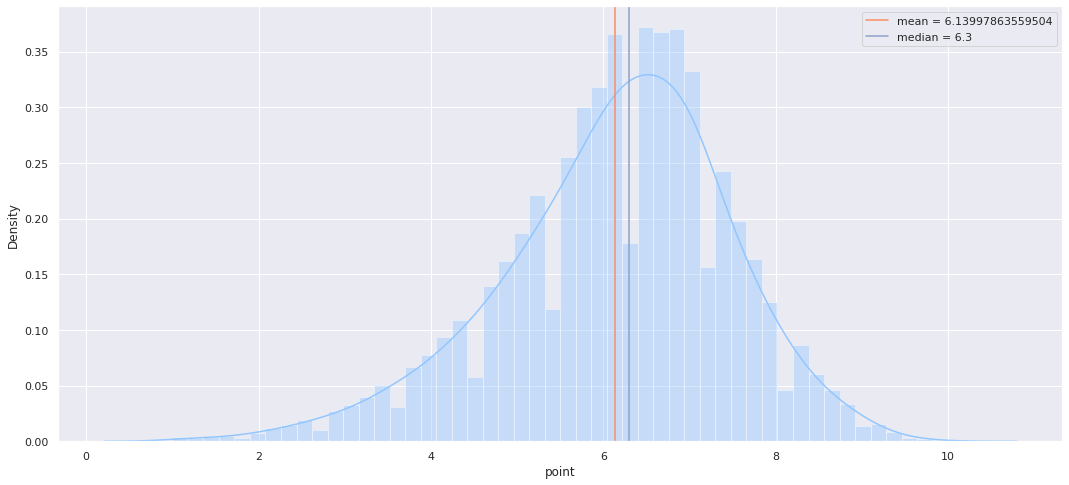

In [5]:
plt.figure(figsize=(18,8))
ax1 = sns.distplot(movie_df['point'], kde_kws=dict(bw=0.2))
ax1.axvline(x=movie_df['point'].mean(),c=sns.color_palette("Set2")[1],
            label=f"mean = {movie_df['point'].mean()}")
ax1.axvline(x=movie_df['point'].median(),c=sns.color_palette("Set2")[2],
            label=f"median = {movie_df['point'].median()}")
plt.legend()

#### 2.2 Correlation between metascore and rating?

total correlation between meta and rating:  0.691248207230778


Text(0.5, 1.0, 'Meta/Rating')

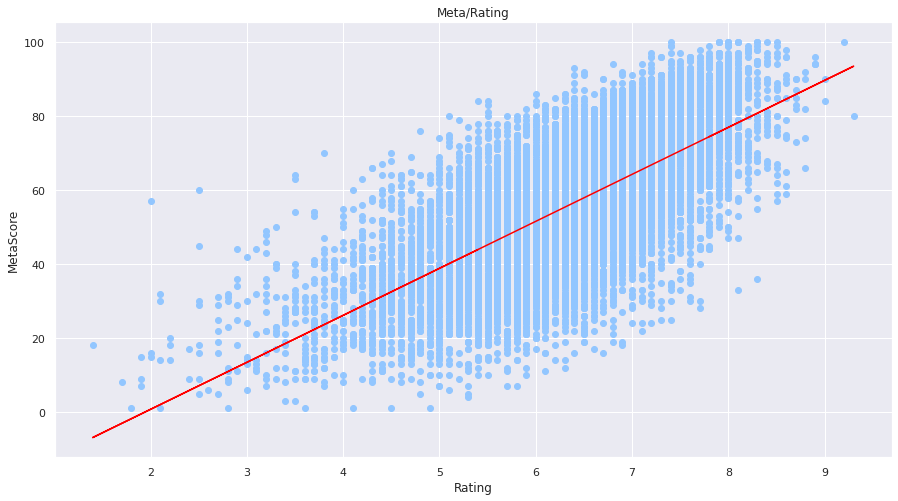

In [6]:
meta_df = movie_df[movie_df['metascore'].notnull()]
print('total correlation between meta and rating: ', meta_df['point'].corr(meta_df['metascore']))

x2 = meta_df['point']
y2 = meta_df['metascore']
plt.figure(figsize=(15,8))
plt.scatter(x2, y2)
m, b = np.polyfit(x2, y2, 1)
plt.plot(x2, m*x2 + b, color="red")
plt.xlabel("Rating")
plt.ylabel("MetaScore")
plt.title("Meta/Rating")

#### 2.3 Rating and metascore for different genres:
please note that *Adult*, *Historical* and *Political* genres do not have metascores.

,name,correlation,count
11,Animation,0.802380,5985
1,Adventure,0.762317,22071
5,Fantasy,0.732886,12090
0,Action,0.726353,39400
12,Sci-Fi,0.719110,10034
3,Crime,0.712682,28762
13,Musical,0.703671,9635
7,Mystery,0.700807,14422
10,Western,0.700376,8136
9,Thriller,0.691919,34556


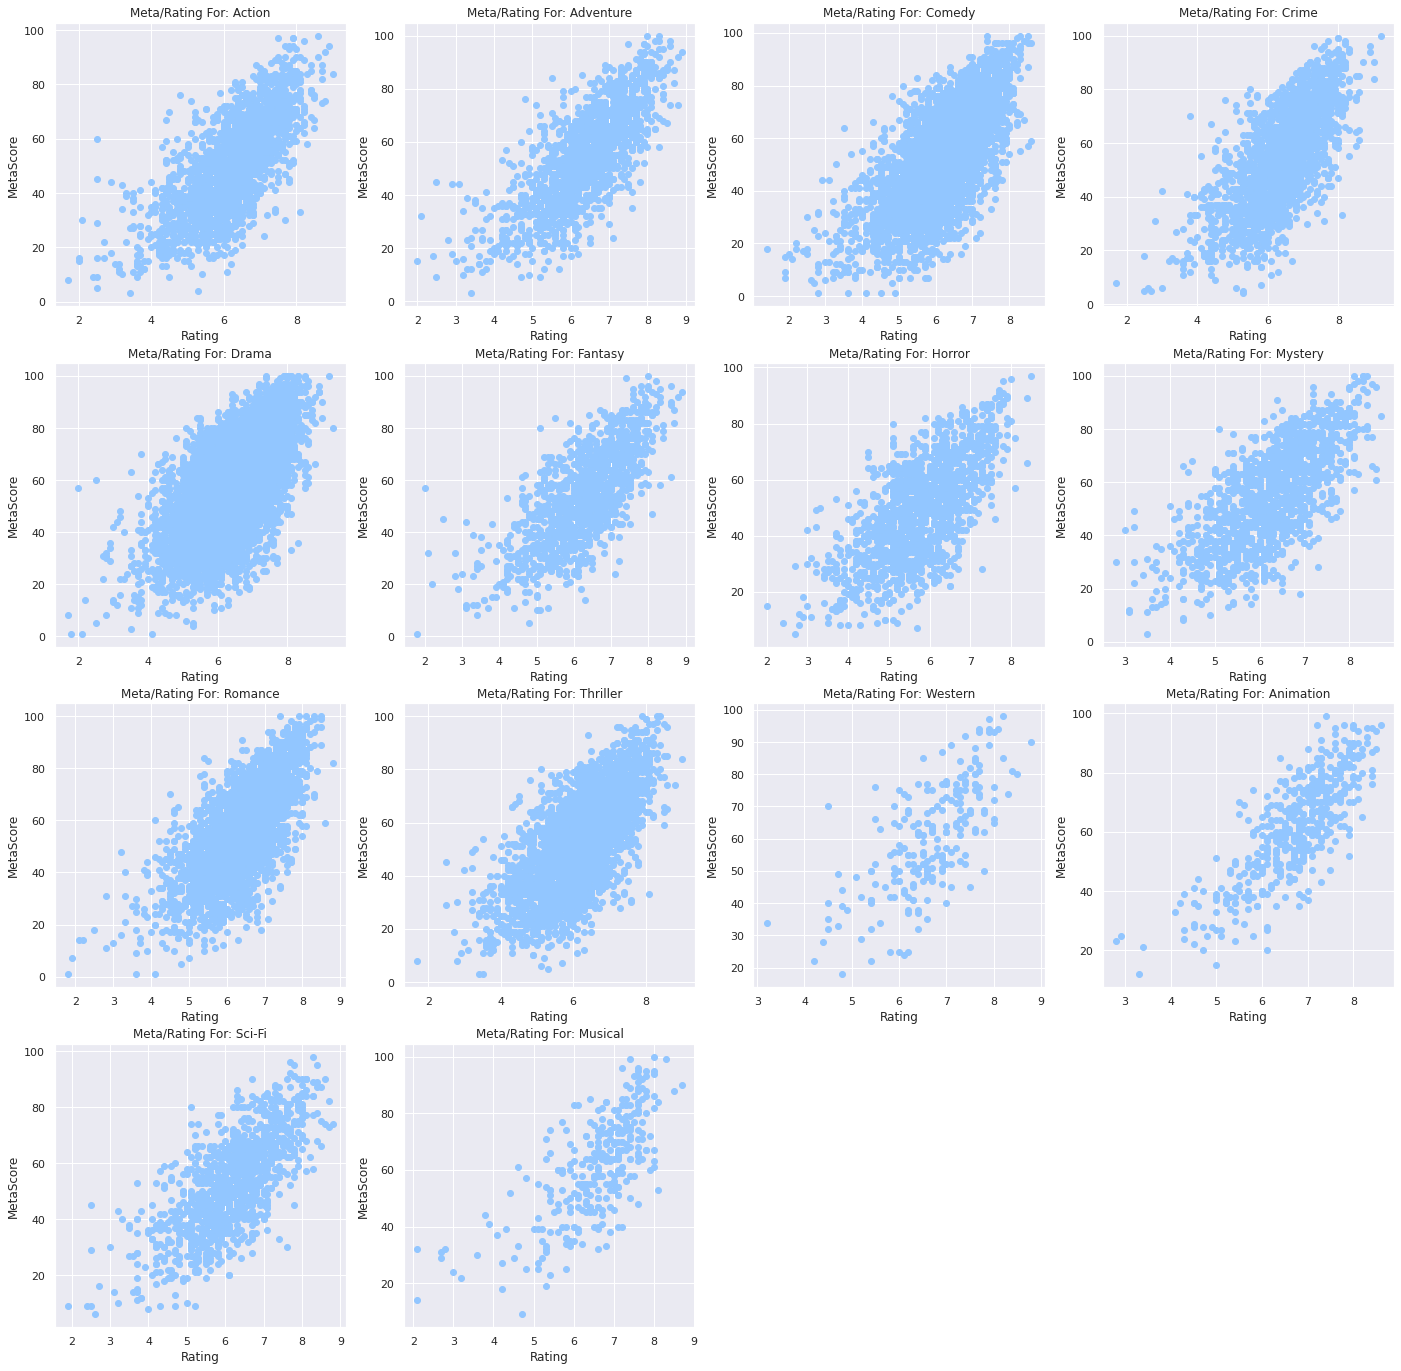

In [7]:
genres_list = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror',
              'Mystery', 'Romance', 'Thriller', 'Western', 'Animation', 'Sci-Fi', 'Musical']

genres_corr_list = []
genres_count = []


plt.figure(figsize=(24, 24))
for i in range (len(genres_list)):
    plt.subplot(4,4,i+1)
    selected_genre = movie_df[movie_df.genres.str.contains(genres_list[i], na=False)]
    genres_corr_list.append(selected_genre['point'].corr(selected_genre['metascore']))
    x,y = selected_genre['point'],selected_genre['metascore']
    genres_count.append(len(y))
    plt.scatter(x, y)
    plt.xlabel("Rating")
    plt.ylabel("MetaScore")
    plt.title("Meta/Rating For: " + genres_list[i])
    
genres_list = np.array(genres_list)
genres_corr_list = np.array(genres_corr_list)
genres_count = np.array(genres_count)
rating_corr_df = pd.DataFrame({'name': genres_list, 'correlation': genres_corr_list, 'count': genres_count}, 
                              columns=['name', 'correlation', 'count'])
rating_corr_df.sort_values(by='correlation', ascending=False)

As we can see above, Those movies that contain *Animation* genre have the higheset correlation between Their IMDB rating and metascore. Least amount of correlation is is For movies that contain *Drama* genre. But pay attention that we have 176K Dramas compared to only 6k Animations!

#### 2.4 Favorite Genre for each user base
Here we are going to analyse what is the favorite genre for each one of the user groups. Those groups are extracted from rating dataframe and are as follows:
* Male Under 18
* Male Between 18 and 29
* Male Between 30 and 44
* Male older than 44
* Female Under 18
* Female Between 18 and 29
* Female Between 30 and 44
* Female older than 44

please note that almost half of the movies of *movie_df* do not have detailed ratings so first we will have to merge those two dataframes and use **inner** to get results.

In [8]:
df = movie_df.merge(rating_df, how='inner')
df.shape

(428298, 88)

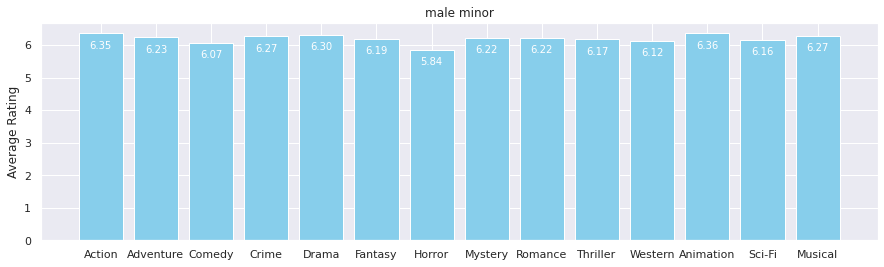

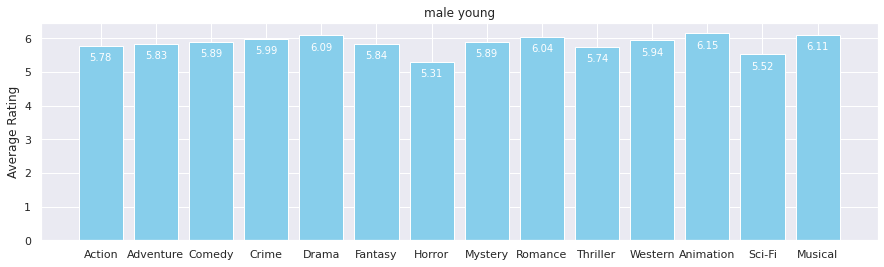

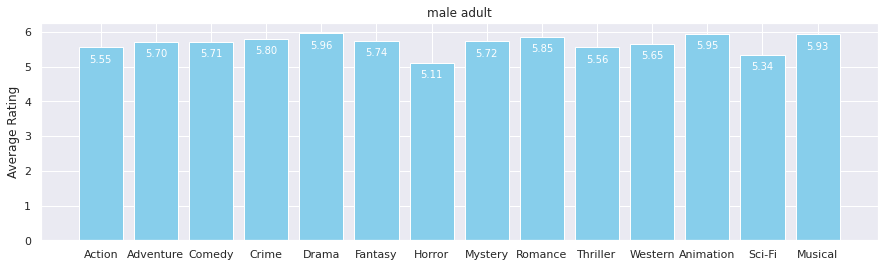

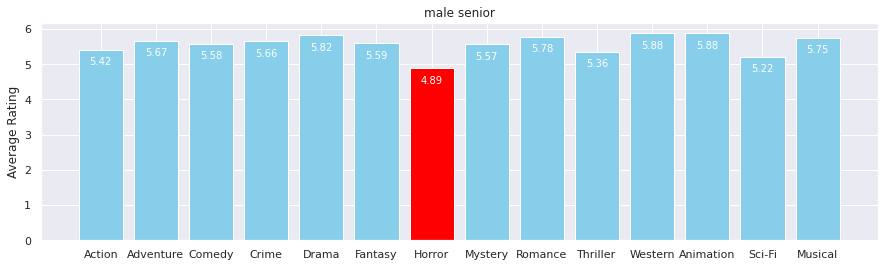

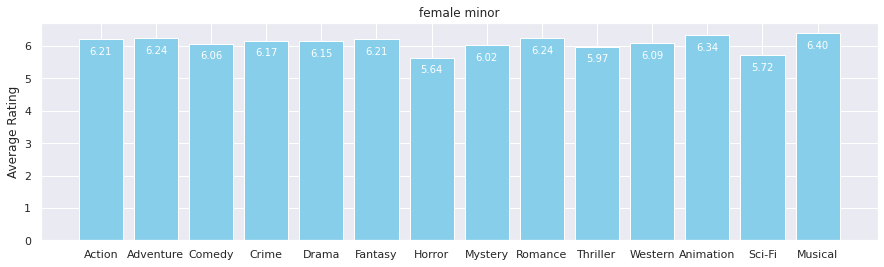

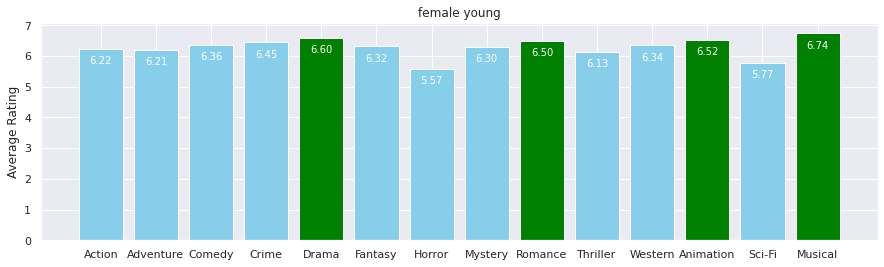

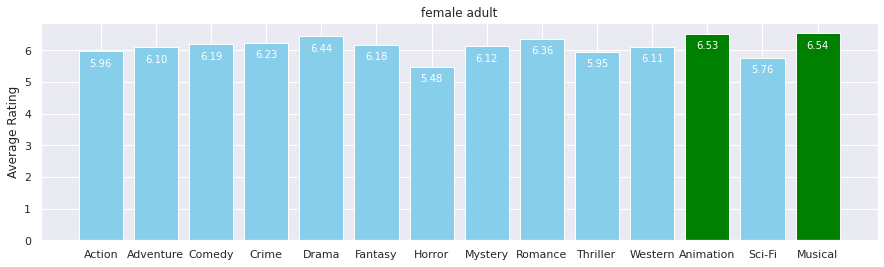

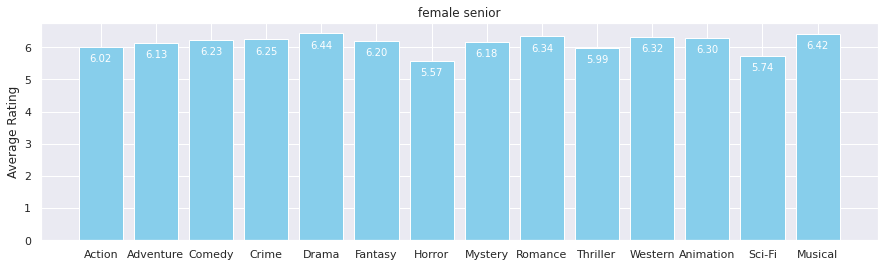

In [9]:
user_groups = ['male_minor_average', 'male_young_average', 'male_adult_average',
              'male_senior_average', 'female_minor_average', 'female_young_average',
              'female_adult_average', 'female_senior_average']

def make_color(lst):
    color = list()
    for y in lst:
        if (y < 5):
            color.append('red')
        elif(y >= 6.5):
            color.append('green')
        else:
            color.append('skyblue')
    return color
    

for j in user_groups:
    rating_dict = {}
    for i in range (len(genres_list)):
        selected_movies = df[df.genres.str.contains(genres_list[i], na=False)]
        selected_column = selected_movies[j]
        rating_dict[genres_list[i]] = selected_column.mean()
    plt.figure(figsize=(15, 4))
    x, y = range(len(rating_dict)), list(rating_dict.values())
    plt.bar(x, y, align='center', color = make_color(y))
    for xtic,ytic in zip(x,y):
      label = "{:.2f}".format(ytic)
      plt.annotate(label, (xtic,ytic), textcoords="offset points", xytext=(0,-15),
                    ha='center', color='white')
    plt.xticks(range(len(rating_dict)), list(rating_dict.keys()))
    plt.ylabel("Average Rating")
    plt.title(' '.join(j.split('_')[0:2]))
    plt.show()

#### 2.5 Top 10 movies of all time?
I will use IMDB's weighted rating formula to calculate score. The formula is as follows:

Weighted Rating (WR) = **(v/v+m) * R + (m/v+m)*C**

> C is the mean rating for the whole dataset

> m is the minimum ratings required to be listed in the chart

> R is the average rating of the movie

> v is the number of ratings for the movie

Before moving on to implementation, we should consider a value for m which is the minimum ratings required to be listed in the chart. I think that **90th** percentile for cutoff is a good choice. I've seen other notebooks choosing 95th percentile but 90th precentile should work as well.


In [10]:
## Calculating m value:
m_value = df['all_count'].quantile(0.9)
m_value

2258.0

In [11]:
## Calculating c value:
c_value = df['all_average'].mean()
c_value

6.12769543635519

In [12]:
## Filtering movies based on m_value:
selected_movies = df[df['all_count'] >= m_value]
len(selected_movies)

42831

As we can see above, m value is **2258** which means that in order to be considered in the competition, a movie must have at least *2258* ratings by different users. After filtering out the dataframe, **42831** movies are actually qualified which is a great number!

Let's now apply the formula to each qualified movie:

In [13]:
def calculate_score(row):
    v , r = row['all_count'], row['all_average']
    return (v/(v+m_value) * r) + (m_value/(m_value+v) * c_value)

selected_movies['wr'] = selected_movies.apply(calculate_score, axis=1)
selected_movies.dropna(subset=['metascore'], how='any', inplace=True)

top10_movies = selected_movies.sort_values('wr', ascending=False)[:10]
top10_movies

,name,org_name,date,title_year,point,point_volume,metascore,user_reviews,critic_reviews,director,writer,story_line,cast,genres,country,language,budget,world_gross,usa_gross,runtime,production_companies,dollar_budget,w_gross_money,u_gross_money,inflation_coeff,casts_id,BlogPage,CompPage,HomePage,release_month,release_day,keywords,tens_count,tens_percent,nines_count,nines_percent,eights_count,eights_percent,sevens_count,sevens_percent,...,twos_percent,ones_count,ones_percent,all_average,all_count,minor_average,minor_count,young_average,young_count,adult_average,adult_count,senior_average,senior_count,male_all_average,male_all_count,male_minor_average,male_minor_count,male_young_average,male_young_count,male_adult_average,male_adult_count,male_senior_average,male_senior_count,female_all_average,female_all_count,female_minor_average,female_minor_count,female_young_average,female_young_count,female_adult_average,female_adult_count,female_senior_average,female_senior_count,top_thousand_average,top_thousand_count,us_users_average,us_users_count,non_us_users_average,non_us_users_count,wr
192037,The Shawshank Redemption,The Shawshank Redemption,1994-10-14,1994.0,9.3,2278363.0,80.0,8232.0,164.0,Frank Darabont,"Stephen King,Frank Darabont",Chronicles the experiences of a formerly succe...,"Tim Robbins,Bob Gunton,Clancy Brown,Mark Rolst...",Drama,USA,English,$25000000,$28815245,$28699976,142.0,Castle Rock Entertainment,25000000.0,2.881524e+07,28699976.0,1.756960,"/name/nm0000209/,/name/nm0348409/,/name/nm0000...",0,0,1,10.0,14.0,"wrongful-imprisonment,based-on-the-works-of-st...",1269356,55.2,587332,25.6,267219,11.6,85570,3.7,...,0.2,34276,1.5,9.3,2298186,9.3,1768,9.3,482625,9.3,873453,9.1,207087,9.3,1397631,9.3,1245,9.3,383869,9.3,729790,9.1,168083,9.2,275473,9.0,254,9.2,87556,9.2,130896,9.2,34802,8.9,908,9.3,328403,9.2,890475,9.296886
130266,The Godfather,The Godfather,1972-03-24,1972.0,9.2,1572285.0,100.0,3978.0,253.0,Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola","The Godfather ""Don"" Vito Corleone is the head ...","Marlon Brando,James Caan,Robert Duvall,John Ma...","Crime,Drama",USA,English,$6000000,$246120974,$134966411,175.0,"Paramount Pictures,Alfran Productions",6000000.0,2.461210e+08,134966411.0,6.239205,"/name/nm0000008/,/name/nm0001001/,/name/nm0000...",0,0,1,3.0,24.0,"crime-family,mafia,patriarch,organized-crime,r...",819544,51.7,392614,24.8,194265,12.2,76705,4.8,...,0.4,36769,2.3,9.2,1585853,9.2,1138,9.2,307803,9.2,626134,9.1,161486,9.2,1008732,9.3,823,9.3,256932,9.2,542579,9.2,135043,8.9,152616,8.8,150,8.9,43835,8.9,74682,8.9,23207,9.1,894,9.2,246404,9.2,635973,9.195632
305199,The Dark Knight,The Dark Knight,2008-07-18,2008.0,9.0,2245394.0,84.0,6966.0,423.0,Christopher Nolan,"Jonathan Nolan,Christopher Nolan",Set within a year after the events of Batman B...,"Christian Bale,Aaron Eckhart,Maggie Gyllenhaal...","Action,Crime,Drama,Thriller","USA,UK","English,Mandarin",$185000000,$1005455335,$535234033,152.0,"Warner Bros.,Legendary Entertainment,Syncopy",185000000.0,1.005455e+09,535234033.0,1.209361,"/name/nm0000288/,/name/nm0001173/,/name/nm0350...",0,0,0,7.0,18.0,"dc-comics,joker,psychopath,clown,criminal-mast...",1015663,44.9,635947,28.1,347770,15.4,135389,6.0,...,0.3,30083,1.3,9.0,2262903,9.2,1908,9.2,514315,9.0,890990,8.4,148139,9.1,1414379,9.3,1412,9.3,415819,9.0,752948,8.4,124742,8.7,251892,8.7,200,8.8,86920,8.7,125766,8.2,20475,8.5,929,9.1,349591,8.9,864403,8.997137
135317,The Godfather: Part II,The Godfather: Part II,1974-12-18,1974.0,9.0,1098457.0,90.0,1030.0,178.0,Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo",The continuing saga of the Corleone crime fami...,"Al Pacino,Diane Keaton,John Cazale,Lee Strasbe...","Crime,Drama",USA,English,$13000000,$48035783,$47834595,202.0,"Paramount Pictures,The Coppola Company,America...",13000000.0,4.803578e+07,47834595.0,5.279327,"/name/nm0000199/,/name/nm0000473/,/name/nm0001...",0,0,1,12.0,18.0,"revenge,corrupt-politician,bloody-body-of-chil...",476479,43.0,3176